# P4 Clustering
Heidi, Rasmus, Artjom, Kaja

Details from instruction:
- Cluster similar research articles together.
- Use at least the abstract and the title of the paper. 
- Build a simple search engine that recommends similar papers based title.

How we can do this?
- We should create embeddings for each paper. We may use whatever features but at least title (and abstract).
- Embeddings can be used for clustering. (We can also make visualizations with the help of dimension reduction - Spark ML PCA!)
- Embeddings can be used for recommending (using distance or similarity metric).

In [0]:
from pyspark.sql.functions import *

### 1. Read the dataset using Spark, common from previous projects
We are utilizing our DW

In [0]:
spark.sql("CREATE TABLE publication USING DELTA LOCATION 'dbfs:/tmp/data/warehouse/publication'")
spark.sql("CREATE TABLE author USING DELTA LOCATION 'dbfs:/tmp/data/warehouse/author'")
spark.sql("CREATE TABLE organization USING DELTA LOCATION 'dbfs:/tmp/data/warehouse/organization'")
spark.sql("CREATE TABLE venue USING DELTA LOCATION 'dbfs:/tmp/data/warehouse/venue'")
spark.sql("CREATE TABLE type USING DELTA LOCATION 'dbfs:/tmp/data/warehouse/type'")
spark.sql("CREATE TABLE fieldofstudies USING DELTA LOCATION 'dbfs:/tmp/data/warehouse/fieldofstudies'")
spark.sql("CREATE TABLE language USING DELTA LOCATION 'dbfs:/tmp/data/warehouse/language'")
spark.sql("CREATE TABLE keyword USING DELTA LOCATION 'dbfs:/tmp/data/warehouse/keyword'")
spark.sql("CREATE TABLE reference USING DELTA LOCATION 'dbfs:/tmp/data/warehouse/reference'")
spark.sql("CREATE TABLE authorrank USING DELTA LOCATION 'dbfs:/tmp/data/warehouse/authorrank'")

Out[2]: DataFrame[]

Loading data to dataframes.

In [0]:
df_rank = (spark.read.format("delta").load("dbfs:/tmp/data/warehouse/authorrank"))
df_publ = (spark.read.format("delta").load("dbfs:/tmp/data/warehouse/publication").select("ID","Title"))
df_fos = (spark.read.format("delta").load("dbfs:/tmp/data/warehouse/fieldofstudies").select("ID","FieldOfStudy"))
df_type = (spark.read.format("delta").load("dbfs:/tmp/data/warehouse/type").select("ID","Type"))
df_keyword = (spark.read.format("delta").load("dbfs:/tmp/data/warehouse/keyword").select("ID","Keyword"))

In [0]:
df = (df_rank
      .join(df_publ, df_publ.ID==df_rank.PublicationID)
      .join(df_fos, df_fos.ID==df_rank.FieldOfStudyID)
      .join(df_type, df_type.ID==df_rank.TypeID)
      .join(df_keyword, df_keyword.ID==df_rank.KeywordID)
      .select("PublicationID","Title","FieldOfStudy","Type","Keyword")
      .dropDuplicates()
     )

display(df)

PublicationID Title FieldOfStudy Type Keyword 3045 Binocular tone mapping Computer Sciences journal-article single arbitrary ldr image 3127 Efficient Parallel Algorithms for Linear Recurrence Computation Computer Sciences journal-article parallel algorithm 3358 Hiding latency in Coarray Fortran 2.0. Computer Sciences proceedings-article fortran standards committee 5175 Clear Separation and Combination of Synchronization Constraint for Concurrent Object Oriented Programming Computer Sciences proceedings-article concurrent object oriented programming 5354 Sensor Networks—Motes, Smart Spaces, and Beyond Computer Sciences journal-article remote base station 2498 High speed video monitoring system for eyelid movement measurements. Computer Sciences proceedings-article hgh speed video monitoring 2942 Bias Specification Language Computer Sciences book-chapter specification language 4251 Building important relationships Computer Sciences proceedings-article internal help desk tool 5059 A Virtual Laboratory for Teaching Linux on the Web Computer Sciences proceedings-article possible irrecoverable damage 2607 A Computational Model of Human Table Tennis for Robot Application. Computer Sciences book-chapter motor skills 3769 A Java program for stereo retinal image visualization. Computer Sciences journal-article stereo retinal image visualization 4403 Analytical Performance Models for MapReduce Workloads. Computer Sciences journal-article task graph 4540 A Virtual-Service-Domain Based Bidding Algorithm for Resource Discovery in Computational Grid Computer Sciences proceedings-article based resource discovery algorithm 4551 Feature extraction method for video based Human action recognitions: Extended Optical Flow algorithm Computer Sciences proceedings-article video processing 5052 The ``Test and Select'' Approach to Ensemble Combination Computer Sciences book-chapter different data source 5185 Braille Printing System Computer Sciences book-chapter variable braille printing system 2658 A Shape Recognition Scheme for Wireless Sensor Networks Based on a Distance Field Method Computer Sciences book-chapter wireless sensor networks 2909 Maximizing credibility-based network utility via power allocation. Computer Sciences proceedings-article wireless networks 3571 Relational reasoning in a nominal semantics for storage Computer Sciences book-chapter relational reasoning principle 3657 Strategies to Enhance the Performance of Path-Based Static Traffic Assignment Algorithms. Computer Sciences journal-article traffic flow 3959 Design exploration of 3D stacked non-volatile memory by conductive bridge based crossbar Computer Sciences proceedings-article conductive bridge based crossbar 4794 The predictive embedded zerotree wavelet (PEZW) coder: low complexity image coding with versatile functionality. Computer Sciences proceedings-article predictive embedded zerotree wavelet coder 4874 Functional programming of real-time reconfigurable embedded systems Computer Sciences journal-article reconfigurable computing 4919 A prototype multiAgent network security system Computer Sciences proceedings-article prototype multiagent network security 5032 Semantics-Based Tools for a Specification-Support Environment Computer Sciences book-chapter support environment 2535 Bayesian Kernel Tracking Computer Sciences book-chapter maximum likelihood parameter esti 3226 Horizontal decompositions and their impact on query solving Computer Sciences journal-article horizontal decomposition 3817 Memory access optimization in compilation for coarse-grained reconfigurable architectures Computer Sciences journal-article pes share memory access 4022 A Comparison of Queuing Models for Handover Strategies in Cellular Mobile Telecommunication Systems Computer Sciences proceedings-article cellular mobile communication system 4939 Extraction of hybrid trace features with evolutionary computation for face recognition Computer Sciences proceedings-article principal component analysis 5

### 2. Do exploratory data analysis to help you extract features

Looking the lengths of titles:

In [0]:
display(df.select(size(split("Title", " ")).alias("Size")).groupBy("Size").count().orderBy("Size"))

Size count 2 146 3 1574 4 13 5 51 6 378 7 416 8 319 9 328 10 288 11 239 12 211 13 143 14 98 15 65 16 42 17 29 18 11 19 8 20 9 21 3 22 7 23 3 24 2 25 2 26 3 29 1

Grouping the papers by field of study, type and keywords...

In [0]:
df.groupBy("FieldOfStudy").count().orderBy(desc("count")).show()

+--------------------+-----+
|        FieldOfStudy|count|
+--------------------+-----+
|   Computer Sciences| 2344|
|         Mathematics| 1047|
|Information sciences|  384|
|Bioengineering an...|  214|
|          Psychology|   68|
|   Physical sciences|   63|
|     Biology Science|   55|
|   Chemical sciences|   29|
|           Sociology|   29|
|Environmental eng...|   20|
|Economics, financ...|   16|
|  Political sciences|   15|
|      Basic medicine|   13|
|Philosophy, ethic...|   13|
|      Earth Sciences|   12|
|Media and communi...|   10|
|Animal and dairy ...|    8|
|                 Law|    7|
|   Civil engineering|    6|
|                Arts|    6|
+--------------------+-----+
only showing top 20 rows



In [0]:
df.groupBy("Type").count().orderBy(desc("count")).show()

+-------------------+-----+
|               Type|count|
+-------------------+-----+
|    journal-article| 2170|
|proceedings-article| 1391|
|       book-chapter|  816|
|      journal-issue|    6|
|    reference-entry|    6|
+-------------------+-----+



In [0]:
df.groupBy("Keyword").count().orderBy(desc("count")).show(10)

+--------------------+-----+
|             Keyword|count|
+--------------------+-----+
|wireless sensor n...|   18|
|learning artifici...|   17|
|      world wide web|   11|
|field programmabl...|    9|
|human computer in...|    8|
|principal compone...|    8|
|additional key words|    8|
|software developm...|    7|
|strategic informa...|    6|
|natural language ...|    6|
+--------------------+-----+
only showing top 10 rows



### 3. Keep only the English documents

There are only english papers in our DW:

In [0]:
%sql select * from language

ID Language 1 en

### 4. Preprocessing

Remove punctuation with regex  '!()-[]{};:'"\,<>./?@#$%^&*_~'

In [0]:
from pyspark.sql.functions import regexp_replace

punct_df = df.withColumn("CleanTitle", regexp_replace('Title', r"[^a-zA-Z]", ' ')) # r"\W"
display(punct_df.select("Title","CleanTitle"))

Title CleanTitle Binocular tone mapping Binocular tone mapping Efficient Parallel Algorithms for Linear Recurrence Computation Efficient Parallel Algorithms for Linear Recurrence Computation Hiding latency in Coarray Fortran 2.0. Hiding latency in Coarray Fortran Clear Separation and Combination of Synchronization Constraint for Concurrent Object Oriented Programming Clear Separation and Combination of Synchronization Constraint for Concurrent Object Oriented Programming Sensor Networks—Motes, Smart Spaces, and Beyond Sensor Networks Motes Smart Spaces and Beyond High speed video monitoring system for eyelid movement measurements. High speed video monitoring system for eyelid movement measurements Bias Specification Language Bias Specification Language Building important relationships Building important relationships A Virtual Laboratory for Teaching Linux on the Web A Virtual Laboratory for Teaching Linux on the Web A Computational Model of Human Table Tennis for Robot Application. A Computational Model of Human Table Tennis for Robot Application A Java program for stereo retinal image visualization. A Java program for stereo retinal image visualization Analytical Performance Models for MapReduce Workloads. Analytical Performance Models for MapReduce Workloads A Virtual-Service-Domain Based Bidding Algorithm for Resource Discovery in Computational Grid A Virtual Service Domain Based Bidding Algorithm for Resource Discovery in Computational Grid Feature extraction method for video based Human action recognitions: Extended Optical Flow algorithm Feature extraction method for video based Human action recognitions Extended Optical Flow algorithm The ``Test and Select'' Approach to Ensemble Combination The Test and Select Approach to Ensemble Combination Braille Printing System Braille Printing System A Shape Recognition Scheme for Wireless Sensor Networks Based on a Distance Field Method A Shape Recognition Scheme for Wireless Sensor Networks Based on a Distance Field Method Maximizing credibility-based network utility via power allocation. Maximizing credibility based network utility via power allocation Relational reasoning in a nominal semantics for storage Relational reasoning in a nominal semantics for storage Strategies to Enhance the Performance of Path-Based Static Traffic Assignment Algorithms. Strategies to Enhance the Performance of Path Based Static Traffic Assignment Algorithms Design exploration of 3D stacked non-volatile memory by conductive bridge based crossbar Design exploration of D stacked non volatile memory by conductive bridge based crossbar The predictive embedded zerotree wavelet (PEZW) coder: low complexity image coding with versatile functionality. The predictive embedded zerotree wavelet PEZW coder low complexity image coding with versatile functionality Functional programming of real-time reconfigurable embedded systems Functional programming of real time reconfigurable embedded systems A prototype multiAgent network security system A prototype multiAgent network security system Semantics-Based Tools for a Specification-Support Environment Semantics Based Tools for a Specification Support Environment Bayesian Kernel Tracking Bayesian Kernel Tracking Horizontal decompositions and their impact on query solving Horizontal decompositions and their impact on query solving Memory access optimization in compilation for coarse-grained reconfigurable architectures Memory access optimization in compilation for coarse grained reconfigurable architectures A Comparison of Queuing Models for Handover Strategies in Cellular Mobile Telecommunication Systems A Comparison of Queuing Models for Handover Strategies in Cellular Mobile Telecommunication Systems Extraction of hybrid trace features with evolutionary computation for face recognition Extraction of hybrid trace features with evolutionary computation for face recognition Thermoelectric and Hybrid Generators in Wearable Devices and Clothes Thermoelectric and Hybr

A tokenizer that converts the input string to lowercase and then splits it by white spaces.

In [0]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(outputCol="Words")
tokenizer.setInputCol("CleanTitle")
tok_df = tokenizer.transform(punct_df)
display(tok_df.select("Title","CleanTitle","Words"))

Title CleanTitle Words Binocular tone mapping Binocular tone mapping List(binocular, tone, mapping) Efficient Parallel Algorithms for Linear Recurrence Computation Efficient Parallel Algorithms for Linear Recurrence Computation List(efficient, parallel, algorithms, for, linear, recurrence, computation) Hiding latency in Coarray Fortran 2.0. Hiding latency in Coarray Fortran List(hiding, latency, in, coarray, fortran) Clear Separation and Combination of Synchronization Constraint for Concurrent Object Oriented Programming Clear Separation and Combination of Synchronization Constraint for Concurrent Object Oriented Programming List(clear, separation, and, combination, of, synchronization, constraint, for, concurrent, object, oriented, programming) Sensor Networks—Motes, Smart Spaces, and Beyond Sensor Networks Motes Smart Spaces and Beyond List(sensor, networks, motes, , smart, spaces, , and, beyond) A note on PM-compact bipartite graphs. A note on PM compact bipartite graphs List(a, note, on, pm, compact, bipartite, graphs) From stars to comets: Improved local search for universal facility location From stars to comets Improved local search for universal facility location List(from, stars, to, comets, , improved, local, search, for, universal, facility, location) Cubes and orientability Cubes and orientability List(cubes, and, orientability) A Note on Sequential Selection from Permutations A Note on Sequential Selection from Permutations List(a, note, on, sequential, selection, from, permutations) Avoiding packaging mismatch with flexible packaging Avoiding packaging mismatch with flexible packaging List(avoiding, packaging, mismatch, with, flexible, packaging) Stable Sensorless Localization of 3-D Objects Stable Sensorless Localization of D Objects List(stable, sensorless, localization, of, , , d, objects) A new ROI grouping schema for automatic image annotation A new ROI grouping schema for automatic image annotation List(a, new, roi, grouping, schema, for, automatic, image, annotation) Active Database Systems Active Database Systems List(active, database, systems) Adaptive Hopfield Network Adaptive Hopfield Network List(adaptive, hopfield, network) Action Language Verifier Action Language Verifier List(action, language, verifier) A Compact/Open Network-Based Controller Incorporating Modular Software Architecture for a Humanoid Robot A Compact Open Network Based Controller Incorporating Modular Software Architecture for a Humanoid Robot List(a, compact, open, network, based, controller, incorporating, modular, software, architecture, for, a, humanoid, robot) Arc consistency revisited Arc consistency revisited List(arc, consistency, revisited) A platform for dynamic microcell redeployment in massively multiplayer online games A platform for dynamic microcell redeployment in massively multiplayer online games List(a, platform, for, dynamic, microcell, redeployment, in, massively, multiplayer, online, games) Determination of G by means of a beam balance Determination of G by means of a beam balance List(determination, of, g, by, means, of, a, beam, balance) UHF Band Short Range Propagation Model UHF Band Short Range Propagation Model List(uhf, band, short, range, propagation, model) High speed video monitoring system for eyelid movement measurements. High speed video monitoring system for eyelid movement measurements List(high, speed, video, monitoring, system, for, eyelid, movement, measurements) Bias Specification Language Bias Specification Language List(bias, specification, language) Building important relationships Building important relationships List(building, important, relationships) A Virtual Laboratory for Teaching Linux on the Web A Virtual Laboratory for Teaching Linux on the Web List(a, virtual, laboratory, for, teaching, linux, on, the, web) Interactive Object Segmentation System from a Video Sequence Interactive Object Segmentation System from a Video Sequence List(interactive, object, segmentation, system, from,

Remove stopwords.

In [0]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

NLTKStopWords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from pyspark.ml.feature import StopWordsRemover

CommonStopWords = ['', 'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure','rights',
'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www']
OurStopWordList = CommonStopWords + NLTKStopWords
remover = StopWordsRemover(inputCol="Words", outputCol="CleanedWords", 
                           stopWords=OurStopWordList)
stop_df = remover.transform(tok_df)
display(stop_df.select("Title","CleanedWords"))

Title CleanedWords Binocular tone mapping List(binocular, tone, mapping) Efficient Parallel Algorithms for Linear Recurrence Computation List(efficient, parallel, algorithms, linear, recurrence, computation) Hiding latency in Coarray Fortran 2.0. List(hiding, latency, coarray, fortran) Clear Separation and Combination of Synchronization Constraint for Concurrent Object Oriented Programming List(clear, separation, combination, synchronization, constraint, concurrent, object, oriented, programming) Sensor Networks—Motes, Smart Spaces, and Beyond List(sensor, networks, motes, smart, spaces, beyond) High speed video monitoring system for eyelid movement measurements. List(high, speed, video, monitoring, system, eyelid, movement, measurements) Bias Specification Language List(bias, specification, language) Building important relationships List(building, important, relationships) A Virtual Laboratory for Teaching Linux on the Web List(virtual, laboratory, teaching, linux, web) A Computational Model of Human Table Tennis for Robot Application. List(computational, model, human, table, tennis, robot, application) A Java program for stereo retinal image visualization. List(java, program, stereo, retinal, image, visualization) Analytical Performance Models for MapReduce Workloads. List(analytical, performance, models, mapreduce, workloads) A Virtual-Service-Domain Based Bidding Algorithm for Resource Discovery in Computational Grid List(virtual, service, domain, based, bidding, algorithm, resource, discovery, computational, grid) Feature extraction method for video based Human action recognitions: Extended Optical Flow algorithm List(feature, extraction, method, video, based, human, action, recognitions, extended, optical, flow, algorithm) The ``Test and Select'' Approach to Ensemble Combination List(test, select, approach, ensemble, combination) Braille Printing System List(braille, printing, system) A Shape Recognition Scheme for Wireless Sensor Networks Based on a Distance Field Method List(shape, recognition, scheme, wireless, sensor, networks, based, distance, field, method) Maximizing credibility-based network utility via power allocation. List(maximizing, credibility, based, network, utility, via, power, allocation) Relational reasoning in a nominal semantics for storage List(relational, reasoning, nominal, semantics, storage) Strategies to Enhance the Performance of Path-Based Static Traffic Assignment Algorithms. List(strategies, enhance, performance, path, based, static, traffic, assignment, algorithms) Design exploration of 3D stacked non-volatile memory by conductive bridge based crossbar List(design, exploration, stacked, non, volatile, memory, conductive, bridge, based, crossbar) The predictive embedded zerotree wavelet (PEZW) coder: low complexity image coding with versatile functionality. List(predictive, embedded, zerotree, wavelet, pezw, coder, low, complexity, image, coding, versatile, functionality) Functional programming of real-time reconfigurable embedded systems List(functional, programming, real, time, reconfigurable, embedded, systems) A prototype multiAgent network security system List(prototype, multiagent, network, security, system) Semantics-Based Tools for a Specification-Support Environment List(semantics, based, tools, specification, support, environment) Bayesian Kernel Tracking List(bayesian, kernel, tracking) Horizontal decompositions and their impact on query solving List(horizontal, decompositions, impact, query, solving) Memory access optimization in compilation for coarse-grained reconfigurable architectures List(memory, access, optimization, compilation, coarse, grained, reconfigurable, architectures) A Comparison of Queuing Models for Handover Strategies in Cellular Mobile Telecommunication Systems List(comparison, queuing, models, handover, strategies, cellular, mobile, telecommunication, systems) Extraction of hybrid trace features with evolutionary computation for face recognition List(extract

[**PorterStemmer**](https://www.nltk.org/howto/stem.html): Stemmers remove morphological affixes from words, leaving only the word stem.

In [0]:
from nltk.stem import PorterStemmer

def stemming(wordlist):
    stemmer = PorterStemmer()
    try:
        stemmed = [stemmer.stem(word) for word in wordlist if len(word)>1]
        return " ".join(stemmed)
    except:
        return None

StemmerUDF = udf(stemming)

stem_df = stop_df.withColumn("StemmedWords", split(StemmerUDF(col("CleanedWords"))," "))
display(stem_df.select("Title","CleanedWords","StemmedWords"))

Title CleanedWords StemmedWords Binocular tone mapping List(binocular, tone, mapping) List(binocular, tone, map) Efficient Parallel Algorithms for Linear Recurrence Computation List(efficient, parallel, algorithms, linear, recurrence, computation) List(effici, parallel, algorithm, linear, recurr, comput) Hiding latency in Coarray Fortran 2.0. List(hiding, latency, coarray, fortran) List(hide, latenc, coarray, fortran) Clear Separation and Combination of Synchronization Constraint for Concurrent Object Oriented Programming List(clear, separation, combination, synchronization, constraint, concurrent, object, oriented, programming) List(clear, separ, combin, synchron, constraint, concurr, object, orient, program) Sensor Networks—Motes, Smart Spaces, and Beyond List(sensor, networks, motes, smart, spaces, beyond) List(sensor, network, mote, smart, space, beyond) A note on PM-compact bipartite graphs. List(note, pm, compact, bipartite, graphs) List(note, pm, compact, bipartit, graph) From stars to comets: Improved local search for universal facility location List(stars, comets, improved, local, search, universal, facility, location) List(star, comet, improv, local, search, univers, facil, locat) Cubes and orientability List(cubes, orientability) List(cube, orient) A Note on Sequential Selection from Permutations List(note, sequential, selection, permutations) List(note, sequenti, select, permut) Avoiding packaging mismatch with flexible packaging List(avoiding, packaging, mismatch, flexible, packaging) List(avoid, packag, mismatch, flexibl, packag) Stable Sensorless Localization of 3-D Objects List(stable, sensorless, localization, objects) List(stabl, sensorless, local, object) A new ROI grouping schema for automatic image annotation List(new, roi, grouping, schema, automatic, image, annotation) List(new, roi, group, schema, automat, imag, annot) Active Database Systems List(active, database, systems) List(activ, databas, system) Adaptive Hopfield Network List(adaptive, hopfield, network) List(adapt, hopfield, network) Action Language Verifier List(action, language, verifier) List(action, languag, verifi) A Compact/Open Network-Based Controller Incorporating Modular Software Architecture for a Humanoid Robot List(compact, open, network, based, controller, incorporating, modular, software, architecture, humanoid, robot) List(compact, open, network, base, control, incorpor, modular, softwar, architectur, humanoid, robot) Arc consistency revisited List(arc, consistency, revisited) List(arc, consist, revisit) A platform for dynamic microcell redeployment in massively multiplayer online games List(platform, dynamic, microcell, redeployment, massively, multiplayer, online, games) List(platform, dynam, microcel, redeploy, massiv, multiplay, onlin, game) Determination of G by means of a beam balance List(determination, g, means, beam, balance) List(determin, mean, beam, balanc) UHF Band Short Range Propagation Model List(uhf, band, short, range, propagation, model) List(uhf, band, short, rang, propag, model) High speed video monitoring system for eyelid movement measurements. List(high, speed, video, monitoring, system, eyelid, movement, measurements) List(high, speed, video, monitor, system, eyelid, movement, measur) Bias Specification Language List(bias, specification, language) List(bia, specif, languag) Building important relationships List(building, important, relationships) List(build, import, relationship) A Virtual Laboratory for Teaching Linux on the Web List(virtual, laboratory, teaching, linux, web) List(virtual, laboratori, teach, linux, web) Interactive Object Segmentation System from a Video Sequence List(interactive, object, segmentation, system, video, sequence) List(interact, object, segment, system, video, sequenc) Progressive wavelet correlation using Fourier methods List(progressive, wavelet, correlation, fourier, methods) List(progress, wavelet, correl, fourier, method) Algebraic pattern matching in join calculus List

Looking at the cleaned and processed title lengths:

In [0]:
display(stem_df.select(size(col("StemmedWords")).alias("Size")).groupBy("Size").count().orderBy("Size"))

Size count 1 5 2 339 3 1394 4 202 5 398 6 461 7 434 8 366 9 279 10 219 11 142 12 73 13 41 14 15 15 7 16 6 17 3 18 3 19 1 22 1

### 5. Vectorization

Word2Vec trains a model of Map(String, Vector), i.e. transforms a word into a code for further natural language processing or machine learning process.
https://datascience.stackexchange.com/questions/51404/word2vec-how-to-choose-the-embedding-size-parameter

In [0]:
from pyspark.ml.feature import Word2Vec

w2v = Word2Vec(vectorSize=100, seed=123, inputCol="StemmedWords", outputCol="Vector", 
               maxSentenceLength=13)
w2v_model = w2v.fit(stem_df)
w2v_df = w2v_model.transform(stem_df)
display(w2v_df.select("PublicationID","Title","Vector"))

PublicationID Title Vector 3045 Binocular tone mapping Map(vectorType -> dense, length -> 100, values -> List(0.00427433755248785, -0.0012589206453412771, 0.001457804348319769, 0.004769894294440746, 5.320056807249784E-4, 0.0011896754925449689, -8.173699801166852E-4, -0.0013841528755923112, -0.0015911099811395009, 0.0017168079502880573, -0.0013669125425318875, 3.5830975199739135E-4, -0.006390367945035298, -4.737373286237319E-4, 8.394668499628702E-4, -7.108412683010101E-4, -0.005038581478099028, -0.001517402318616708, 0.004940809992452462, -8.235786420603592E-4, 0.003212826947371165, -0.0015130297591288884, -0.0011711624295761187, 0.004525371206303437, 1.71070103533566E-4, -0.0025703581050038338, -0.0012818300165235996, 7.928460060308377E-4, -0.0027805641293525696, 0.002922698544959227, 0.0057316602518161135, 0.0025037270970642567, 0.003838708934684594, -0.0037370532130201655, 0.003633203605810801, -0.0036167216797669726, -0.00407838604102532, -0.006649306043982506, -0.0022826370162268477, -0.0019324983780582745, 0.002994089387357235, 0.0040017953142523766, -0.004336581565439701, -0.001193672806645433, -0.004117100810011228, 0.0024529209670921164, -0.0011562544386833906, -0.006731065611044565, 0.004174950222174326, 0.0023728194646537304, 0.0024393067384759584, -0.001259926085670789, -0.010329406708478928, 2.7211992225299275E-4, -0.007259166489044825, -0.0011064233258366585, 2.004965596521894E-4, 0.002592963942637046, -0.0016023040128250916, 2.869641175493598E-4, 0.0010539170665045579, -1.6713078366592526E-4, 0.002604755572974682, -0.0013202310850222905, -0.002414246865858634, -0.0021207029931247234, -0.0014882922793428102, 0.003944015440841516, 5.645508257051308E-4, -9.176832779000202E-4, -2.7296696013460553E-4, 0.0016382553925116856, -5.522738986959059E-4, 0.004694273074467977, -3.798774365956584E-4, -0.004680297958354155, -0.004556049903233846, -6.786480080336332E-4, 1.5626517900576192E-4, -0.0025079807577033835, 0.004116741940379143, 0.00148687573770682, 0.004013326019048691, -0.0034395282467206316, 0.0014651156961917877, -3.2620605391760665E-4, 0.0039845096568266545, -0.0035132250438133874, 8.187980080644289E-4, -2.09993760411938E-4, 9.715262179573377E-5, -0.0011321022951354582, -0.003130294382572174, -3.35721779265441E-5, -0.0074652861803770065, 0.00211279218395551, 0.004469403065741062, 0.0020398679189383984, -0.0012498322563866773, -0.004411034286022186)) 3127 Efficient Parallel Algorithms for Linear Recurrence Computation Map(vectorType -> dense, length -> 100, values -> List(0.023487350825841226, -6.788742854647959E-4, 0.007424385267465064, 0.03692106912300611, -0.002839439534000121, 0.010276681665952006, -0.003327684224738429, -0.001534056738213015, -0.01116758914819608, 0.011978147784247994, -0.00639744192691675, 0.0012094393641746137, -0.04130587951901058, -0.008231802499115776, -0.0030888787005096674, -0.010098783056794975, -0.030214816409473617, -0.0031634609525402384, 0.028386587277054787, -0.01875085445741812, 0.019782272303321708, -0.022122076246887445, -0.001978010463062674, 0.02608211509262522, 0.009928342575828234, -0.011518933994617933, -0.013511466095224023, 0.006196429564928015, -0.009419135516509414, 0.02163164368054519, 0.03143559194480379, 0.016865111014340073, 0.018447152455337346, -0.019292337199052174, 0.03115037797639767, -0.021518305875360966, -0.016406146120668076, -0.03424700074053059, -0.00796929802163504, -0.007699039105015496, 0.009408621427913506, 0.02414012044512977, -0.016614424802052476, -0.013375996534402171, -0.028723134426400065, 0.003337983216624707, -0.004522530517230431, -0.03175344729485611, 0.019154557104532916, 0.017177616828121245, 0.013060024629036585, -0.009955636017063322, -0.06156038888730109, 0.011607429497720052, -0.03848379796060423, -0.010341530316509306, 0.005235569881430516, 0.018590420329322416, -0.01401561025219659, -0.002518317555465425, 0.003321612617583014, -0.0043381593241065275, 0.024213102413341403, -0.014995873828108111, -0.0069520522859723615, -0.0031992355555

### 6. Clustering

Using **PCA** to reduce the word-vector dimensionality.

In [0]:
from pyspark.ml.feature import PCA

pca = PCA(k=100, inputCol="Vector", outputCol="PCAReduced")
pca_model = pca.fit(w2v_df)
pca_model.transform(w2v_df).select("PublicationID","PCAReduced").show(5)

+-------------+--------------------+
|PublicationID|          PCAReduced|
+-------------+--------------------+
|         3045|[-0.0300660240722...|
|         3127|[-0.1913315198780...|
|         3358|[-0.0190544546080...|
|         2498|[-0.0723375396625...|
|         2942|[-0.1209231440939...|
+-------------+--------------------+
only showing top 5 rows



Calculating the explained variance:

In [0]:
pca_model.explainedVariance

Out[33]: DenseVector([0.9308, 0.0148, 0.0041, 0.0032, 0.0021, 0.0018, 0.0016, 0.0013, 0.0012, 0.0012, 0.0011, 0.001, 0.0009, 0.0009, 0.0009, 0.0008, 0.0008, 0.0008, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001])

In [0]:
import numpy as np

explVar = list(pca_model.explainedVariance)
np.cumsum(explVar)

Out[34]: array([0.93075854, 0.94560608, 0.94968456, 0.95286849, 0.95494966,
       0.95670321, 0.95827335, 0.9595956 , 0.96084121, 0.9620322 ,
       0.96313731, 0.96414687, 0.96508214, 0.96599781, 0.96686081,
       0.96769275, 0.96848957, 0.96925652, 0.96999815, 0.97073118,
       0.97142884, 0.97211596, 0.97278079, 0.97344016, 0.97407944,
       0.97471143, 0.97533672, 0.97594168, 0.97653354, 0.97711716,
       0.97769045, 0.97824671, 0.97879223, 0.97933476, 0.97987269,
       0.98039537, 0.98090991, 0.98141072, 0.98190495, 0.98238659,
       0.98285475, 0.98331468, 0.98377222, 0.98422432, 0.98467345,
       0.98511087, 0.9855359 , 0.98595148, 0.98636023, 0.98676229,
       0.98716318, 0.98755066, 0.98793442, 0.98830953, 0.98868172,
       0.98904328, 0.9893992 , 0.98974983, 0.99009216, 0.9904239 ,
       0.99075368, 0.9910814 , 0.99140461, 0.99171998, 0.99202988,
       0.99233601, 0.99263502, 0.99292808, 0.99321932, 0.99350369,
       0.9937843 , 0.99405947, 0.99433311, 0.99459781

At least 95% variance is explained by 4 features.

In [0]:
pca = PCA(k=4, inputCol="Vector", outputCol="PCAReduced")
pca_model = pca.fit(w2v_df)
pca_df = pca_model.transform(w2v_df)

Finding K for **K-means** with the **elbow** method.

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd 
import pylab as pl

df_X = pca_df.select("PublicationID","Title","FieldOfStudy","Type","Keyword","Vector",col("PCAReduced").alias("features"))
score = []

for k in range(4,40,4):
    kmeans = KMeans(k=k, seed=3) #, distanceMeasure='cosine')
    k_model = kmeans.fit(df_X)
    k_df = k_model.transform(df_X)
    evaluator = ClusteringEvaluator()
    score.append(evaluator.evaluate(k_df))

# ~17-18 min!

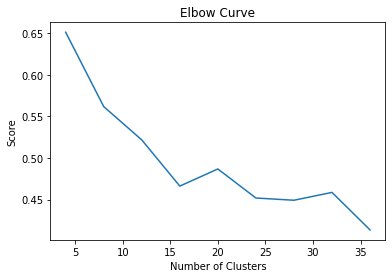

In [0]:
df_scores = pd.DataFrame({"Score": score, "Cluster": range(4,40,4)})

pl.plot(df_scores.Cluster, df_scores.Score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

**K-means**: clustering with the best K=16.

In [0]:
K=16
kmeans = KMeans(k=K, seed=3) #, distanceMeasure='cosine')
k_model = kmeans.fit(df_X)
k_df = k_model.transform(df_X)
centers = k_model.clusterCenters()
k_df.select("Title","FieldOfStudy","Type","Keyword","prediction").show(10)

+--------------------+-----------------+-------------------+--------------------+----------+
|               Title|     FieldOfStudy|               Type|             Keyword|prediction|
+--------------------+-----------------+-------------------+--------------------+----------+
|Binocular tone ma...|Computer Sciences|    journal-article|single arbitrary ...|        13|
|Efficient Paralle...|Computer Sciences|    journal-article|  parallel algorithm|        11|
|Hiding latency in...|Computer Sciences|proceedings-article|fortran standards...|        10|
|High speed video ...|Computer Sciences|proceedings-article|hgh speed video m...|         1|
|Bias Specificatio...|Computer Sciences|       book-chapter|specification lan...|        14|
|A Computational M...|Computer Sciences|       book-chapter|        motor skills|         8|
|A Java program fo...|Computer Sciences|    journal-article|stereo retinal im...|        14|
|A Shape Recogniti...|Computer Sciences|       book-chapter|wireless s

In [0]:
display(
    k_df.groupBy("prediction").count().orderBy("prediction")
)

prediction count 0 219 1 407 2 491 3 320 4 11 5 382 6 432 7 299 8 149 9 88 10 331 11 91 12 391 13 344 14 395 15 39

**Visualizing results** using first two components

In [0]:
import matplotlib.pyplot as plt
import random

def plot(COLUMN):
    df_p = k_df.select("features",COLUMN).toPandas()
    values = df_p[COLUMN].unique()
    cmap = {value: "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for value in values}
    df_p["x"] = df_p["features"].apply(lambda x: x[0])
    df_p["y"] = df_p["features"].apply(lambda x: x[1])
    df_p["color"] = df_p[COLUMN].apply(lambda x: cmap[x])
    
    plt.figure(figsize=(8,8))
    plt.scatter(x=df_p.x,y=df_p.y,c=df_p.color)
    plt.title(f'Grouping by {COLUMN}')
    plt.show()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


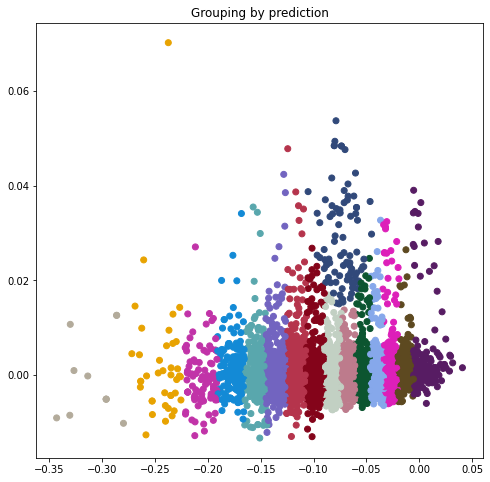

In [0]:
plot("prediction")

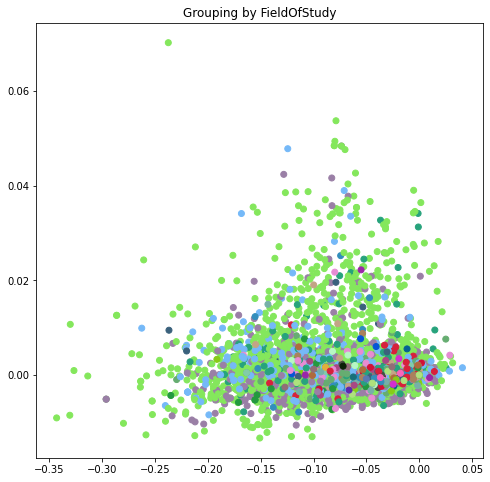

In [0]:
plot("FieldOfStudy")

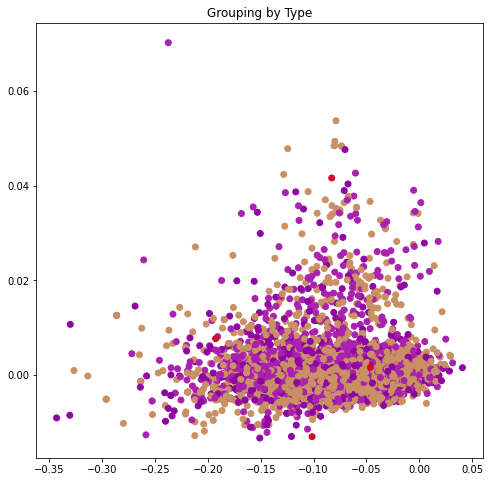

In [0]:
plot("Type")

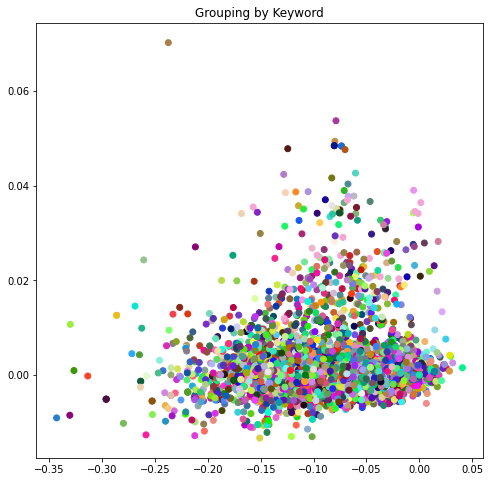

In [0]:
plot("Keyword")

### 7. Search engine aka Recommender
Recommender function that takes as input **a paper title** and **N** as the top-most N closest papers. Recommendation is made for the top N most similar (**Cosine similarity**) papers to the input paper title in the cluster to which it belongs.

In [0]:
from pyspark.ml.functions import vector_to_array
from sklearn.metrics.pairwise import cosine_similarity

def Recommender(Title,N):
    cluster_n = k_df.filter(col("Title")==Title).select("prediction").first()[0]
    same_df = k_df.filter(col("prediction")==cluster_n).withColumn("Array",vector_to_array("features")) 
    Arr1 = same_df.filter(col("Title")==Title).select("Array").first()[0]
    df_p = same_df.select("PublicationID","Title","FieldOfStudy","Type","Keyword","prediction","Array").filter(col("Title")!=Title).toPandas()
    df_p["Similarity"] = df_p["Array"].apply(lambda x: cosine_similarity([x],[Arr1])[0][0])
    return df_p.sort_values("Similarity",ascending=False).head(N)

Example 1:

In [0]:
N=10
Title = "A Computational Model of Human Table Tennis for Robot Application."
Recommender(Title,N)

PublicationID 
 Title 
 FieldOfStudy 
 Type 
 Keyword 
 prediction 
 Array 
 Similarity 
 
 
 
 
 53 
 4604 
 Time-optimal control in a single machine probl... 
 Bioengineering and Biomedical engineering 
 journal-article 
 single machine 
 8 
 [-0.18076545475030614, -0.0014299807335133867,... 
 0.999933 
 
 
 118 
 3246 
 Real-time Supervisory Control and Scheduling f... 
 Computer Sciences 
 proceedings-article 
 transition petri net 
 8 
 [-0.16578474582307023, -0.0009321888049571972,... 
 0.999925 
 
 
 104 
 5453 
 Real-Time Scheduling for Multi-agent Call Cent... 
 Computer Sciences 
 book-chapter 
 agent call center automation 
 8 
 [-0.17167352833932129, -0.00026868067900560097... 
 0.999916 
 
 
 11 
 3716 
 Bunched Logic Programming 
 Computer Sciences 
 book-chapter 
 logic programming language blp 
 8 
 [-0.1786160969170744, -0.00489691923416011, -0... 
 0.999901 
 
 
 105 
 6393 
 Antitonic Logic Programs 
 Computer Sciences 
 book-chapter 
 generalized annotated logic programs 
 8 
 [-0.1786160969170744, -0.00489691923416011, -0... 
 0.999901 
 
 
 112 
 6548 
 Autoepistemic logic programming 
 Mathematics 
 journal-article 
 heterogeneous program modules 
 8 
 [-0.1786160969170744, -0.00489691923416011, -0... 
 0.999901 
 
 
 56 
 6491 
 Autonomous interface agents 
 Computer Sciences 
 proceedings-article 
 autonomous interface agent 
 8 
 [-0.17861445414446228, -0.0005264155439393272,... 
 0.999883 
 
 
 128 
 2928 
 Behavioural virtual agents 
 Computer Sciences 
 book-chapter 
 behavioural virtual agent 
 8 
 [-0.1858639931316061, -0.0004300768198807545, ... 
 0.999872 
 
 
 14 
 3097 
 DEXT: an integrated knowledge-engineering envi... 
 Computer Sciences 
 journal-article 
 rule base 
 8 
 [-0.1733968941442325, -0.0018195857360441047, ... 
 0.999872 
 
 
 31 
 5819 
 A general treatment of dynamic integrity const... 
 Computer Sciences 
 journal-article 
 dynamic integrity constraints 
 8 
 [-0.18684993506926426, -0.005190881433917131, ... 
 0.999870

Example 2:

In [0]:
N=10
Title = "Efficient Parallel Algorithms for Linear Recurrence Computation"
Recommender(Title,N)

PublicationID 
 Title 
 FieldOfStudy 
 Type 
 Keyword 
 prediction 
 Array 
 Similarity 
 
 
 
 
 48 
 6079 
 Ambiguous algorithms (abstract) 
 Computer Sciences 
 proceedings-article 
 software engineering 
 11 
 [-0.20548241346856494, -0.00494429410894041, 0... 
 0.999988 
 
 
 40 
 6334 
 Algorithmically independent sequences 
 Computer Sciences 
 journal-article 
 arbitrary infinite binary sequence 
 11 
 [-0.2211505665456506, -0.008261369346952244, 0... 
 0.999949 
 
 
 7 
 5386 
 Chaotic bat algorithm. 
 Computer Sciences 
 journal-article 
 global optimization 
 11 
 [-0.21233002643579615, -0.004285768708436284, ... 
 0.999910 
 
 
 12 
 6993 
 Affinity genetic algorithm 
 Computer Sciences 
 journal-article 
 selection degree 
 11 
 [-0.19195272513518705, -0.0017019726277770699,... 
 0.999825 
 
 
 73 
 6344 
 Algorithmic invariant theory 
 Mathematics 
 proceedings-article 
 computational commutative algebra 
 11 
 [-0.21511937000014691, -0.009503038422552955, ... 
 0.999819 
 
 
 38 
 6873 
 Algorithmic Folding Complexity 
 Mathematics 
 journal-article 
 valley patterns require � n 
 11 
 [-0.19168384397416727, -0.0032873519710424027,... 
 0.999782 
 
 
 17 
 6717 
 Algorithmic Folding Complexity 
 Mathematics 
 book-chapter 
 maximum possible folding complexity 
 11 
 [-0.19168384397416727, -0.0032873519710424027,... 
 0.999782 
 
 
 51 
 6946 
 Algorithmic Relative Complexity. 
 Mathematics 
 journal-article 
 compression based distance 
 11 
 [-0.19168384397416727, -0.0032873519710424027,... 
 0.999782 
 
 
 68 
 4293 
 Block-iterative algorithms 
 Mathematics 
 journal-article 
 iterative algorithm 
 11 
 [-0.20392346965476477, -0.010363794278049794, ... 
 0.999705 
 
 
 56 
 4555 
 Efficient parallel algorithms for molecular dy... 
 Computer Sciences 
 journal-article 
 molecular dynamics simulation 
 11 
 [-0.1969398862840644, -0.0044113275462489936, ... 
 0.999636

<hr>


**Abstract**

We did not have the <u>Abstract</u> feature for papers. But if we had it then we would have preprocessed and used it as we did it with <u>Title</u>. The Abstract would have had longer vector and it would have made the training K-Means longer than we had it now. But we believe that we would gain more information from Abstract. Processing and training would be longer with our computational resources. Our intention was to avoid long calculation time.